Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2613 - Inteligencia Artificial
<br>

<center>
    <h2> Ayudantía 8 </h2>
    <h1> Árboles de decisión y Random Forest </h1>
    <p>
        Felipe Guzmán: faguzman2@uc.cl  <br> 
        Ignacio Villanueva: ignacio.villanueva@uc.cl<br>
        2022 - 1    
    </p>
    <br>
    <img src="https://www.researchgate.net/profile/Jessica-Pickles-2/publication/339279807/figure/fig1/AS:891889284829201@1589654384981/Random-forests-are-collections-of-randomised-decision-trees-A-A-single-decision-tree.ppm" width="600"/>
</center>

<br>

---

# SpaceShip Titanic

Vives en el año 2122, y quieres comprar un pasaje en el nuevo Spaceship Titanic II. Sin embargo, te enteras que hace 20 años existió un primer Spaceship Titanic, que es exactamente igual al segundo, y en este se produjo un incidente que hizo que parte de los pasajeros fueran transportados a otra dimensión.

Contra tu mejor juicio, decides comprar de todas formas el pasaje, pero tomando la precaución de elegir un viaje tal que no seas transportado a otra dimensión. Para esto, decides utilizar el método de clasificación Random Forest, para lograr decidir, a partir de la información que tienes del primer Spaceship Titanic, cuales de los viajes disponibles no llevaran a un viaje interdimensional.

El [siguiente dataset](https://www.kaggle.com/competitions/spaceship-titanic/data) fue extraído de [`Kaggle`](https://www.kaggle.com/). Esta página tiene muchos datasets de diversos temas, y también trabajos de personas sobre algunos de estos sets, por lo que si tienen ganas de hacer algún proyecto de este estilo, les recomendamos revisar esta página.

A continuación importaremos los datasets:

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset = pd.read_csv("train.csv", index_col = False)

Luego de tener nuestros datasets, lo primero que hacemos es ver sus características, y la de sus columnas para saber con que estamos trabajando. Lo primero que haremos es ver sus primeras filas y revisarlas.

In [ ]:
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


También nos interesa revisar el tamaño de nuestro dataset, por lo que lo revisamos a continuación

In [ ]:
print(f"Tamaño de nuestro dataset: {dataset.shape}")

Tamaño de nuestro dataset: (8693, 14)


Como queremos usar un árbol de decisión, hay ciertas columnas que no nos sirven, como sería el caso de `PassengerId`, `Name` y `Cabin`, debido a que realmente no generan una separación en los datos. Sabiendo esto, podemos eliminar estas columnas. 

In [ ]:
dataset = dataset.drop(labels=["PassengerId", "Name", "Cabin"], axis=1)

A su vez, revisamos la cantidad de catégorias por columna. 

In [ ]:
dataset.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Transported        2
dtype: int64

Podemos observar que las columnas `Age, RoomService, FoodCourt,	ShoppingMall,	Spa, VRDeck` son de tipo continuas. Recordemos que el árbol de decisión necesita variables categóricas para su funcionamiento, por lo que debemos transformar las columnas a este tipo de datos.

Es por esto que transformaremos `Age` en categórica. El resto las eliminaremos por simplicidad del ejercicio.

Separaremos `Age` en tres categorías:

1.   `Young`: `0 <= Age < 30` 
2.   `Adult`: `30 <= Age < 60`
3.   `Elderly`: `60 < Age <= 99`


In [ ]:
dataset['Age'] = pd.cut(dataset.Age,bins=[-1, 30, 60, 99],labels=["Young", "Adult", "Elderly"])
dataset = dataset.drop(labels=["RoomService",	"FoodCourt",	"ShoppingMall",	"Spa"	, "VRDeck"], axis=1)

Ahora revisemos el dataset para ver como quedó luego de esta transformación. 

In [ ]:
dataset.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported
0,Europa,False,TRAPPIST-1e,Adult,False,False
1,Earth,False,TRAPPIST-1e,Young,False,True
2,Europa,False,TRAPPIST-1e,Adult,True,False
3,Europa,False,TRAPPIST-1e,Adult,False,False
4,Earth,False,TRAPPIST-1e,Young,False,True


Luego de eliminar las columnas correspondientes y transformar los datos a su tipo correspondiente, nos interesa saber si tenemos datos nulos

In [ ]:
dataset.isnull().sum()

HomePlanet     201
CryoSleep      217
Destination    182
Age            179
VIP            203
Transported      0
dtype: int64

Como podemos ver, tenemos datos nulos en casi todas las columnas. Cuando tenemos esta situación tenemos 2 opciones:


1.   Si consideran que esas filas no aportan gran información al problema, podemos eliminarlas.
2.   Si no quieren perder esos datos, se pueden reemplazar los datos vacíos con algún valor que tenga sentido según los datos. Esto puede ser reemplazar según la moda, el promedio en el caso de los valores continuos, etc.

En ambos casos lo importante es justificar debidamente las decisiones que se tomen.

En este caso, reemplazaremos la columna `VIP` con la moda debido a que es una columna con dos categórias, por lo que puede ser una buena fuente de separación en los datos, por lo que no queremos perder esos datos. Para esto primero revisaremos cual es la moda de esta columna.
Por otro lado, eliminaremos las otras filas con valores nulos por simplicidad.



In [ ]:
dataset["VIP"].describe()

count      8490
unique        2
top       False
freq       8291
Name: VIP, dtype: object

Como podemos ver, el valor `False` es el que más se repite, por lo que reemplazaremos las filas vacías con esta categoría.

In [ ]:
dataset["VIP"] = dataset["VIP"].fillna(False)

Para revisar que este correcto, volvemos a revisar los nulos en el dataset.

In [ ]:
dataset.isnull().sum()

HomePlanet     201
CryoSleep      217
Destination    182
Age            179
VIP              0
Transported      0
dtype: int64

Podemos observar que efectivamente fueron reemplazados estos valores. A continuación eliminaremos el resto de las filas con datos vacíos

In [ ]:
dataset = dataset.dropna()

Revisamos nuevamente el dataset.

In [ ]:
dataset.isnull().sum()

HomePlanet     0
CryoSleep      0
Destination    0
Age            0
VIP            0
Transported    0
dtype: int64

In [ ]:
dataset.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported
0,Europa,False,TRAPPIST-1e,Adult,False,False
1,Earth,False,TRAPPIST-1e,Young,False,True
2,Europa,False,TRAPPIST-1e,Adult,True,False
3,Europa,False,TRAPPIST-1e,Adult,False,False
4,Earth,False,TRAPPIST-1e,Young,False,True


Ahora que tenemos el dataset limpio, tenemos que dejarlo listo para que el árbol de decisión pueda usarlo. Para esto, primero debemos transformar las columnas categóricas de string a un valor numérico. Para esto usaremos el método `get_dummies`, que genera una columna de 0 y 1, por cada categoría de la columna original. (Esto se llama [`One Hot Encoding`](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/one-hot-encoding)). Veamos un ejemplo con la columna `HomePlanet`.

In [ ]:
pd.get_dummies(dataset, columns=["HomePlanet"]).head()

,CryoSleep,Destination,Age,VIP,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,False,TRAPPIST-1e,Adult,False,False,0,1,0
1,False,TRAPPIST-1e,Young,False,True,1,0,0
2,False,TRAPPIST-1e,Adult,True,False,0,1,0
3,False,TRAPPIST-1e,Adult,False,False,0,1,0
4,False,TRAPPIST-1e,Young,False,True,1,0,0


In [ ]:
dataset = pd.get_dummies(dataset, columns=["HomePlanet", "Destination",	"Age"])

In [ ]:
dataset.head()

,CryoSleep,VIP,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age_Young,Age_Adult,Age_Elderly
0,False,False,False,0,1,0,0,0,1,0,1,0
1,False,False,True,1,0,0,0,0,1,1,0,0
2,False,True,False,0,1,0,0,0,1,0,1,0
3,False,False,False,0,1,0,0,0,1,0,1,0
4,False,False,True,1,0,0,0,0,1,1,0,0


A continuación, como en las columnas `CryoSleep, VIP, Transported` tenemos solo valores `True` o `False`, transformaremos cada columna en una nueva con 0 ( = False) y 1 (= True).
 
Para esto, usaremos el método `LabelEncoder`.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()
dataset["CryoSleep"] = encoder.fit_transform(dataset["CryoSleep"])
dataset["VIP"] = encoder.fit_transform(dataset["VIP"])
dataset["Transported"] = encoder.fit_transform(dataset["Transported"])

In [ ]:
dataset.head()

,CryoSleep,VIP,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age_Young,Age_Adult,Age_Elderly
0,0,0,0,0,1,0,0,0,1,0,1,0
1,0,0,1,1,0,0,0,0,1,1,0,0
2,0,1,0,0,1,0,0,0,1,0,1,0
3,0,0,0,0,1,0,0,0,1,0,1,0
4,0,0,1,1,0,0,0,0,1,1,0,0


Por último, nos interesa saber cual es el tamaño final de nuestro dataset para saber con que trabajaremos.

In [ ]:
dataset.shape

(7930, 12)

Ahora que tenemos nuestro set de datos listo, debemos separarlo en la matriz de características (`X`) y el vector de etiquetas (labels, `y`) para trabjar con el.

In [ ]:
X_data = dataset.loc[:, dataset.columns != 'Transported']
y_data = dataset['Transported']

In [ ]:
X_data

,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age_Young,Age_Adult,Age_Elderly
0,0,0,0,1,0,0,0,1,0,1,0
1,0,0,1,0,0,0,0,1,1,0,0
2,0,1,0,1,0,0,0,1,0,1,0
3,0,0,0,1,0,0,0,1,0,1,0
4,0,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,1,0,1,0,0,0,1,0
8689,1,0,1,0,0,0,1,0,1,0,0
8690,0,0,1,0,0,0,0,1,1,0,0
8691,0,0,0,1,0,1,0,0,0,1,0


In [ ]:
y_data

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 7930, dtype: int64

El último paso que tenemos que hacer, es separar nuestros datos en tres sets, `train, validation, test`. Para esto, usaremos el método `train_test_split` de `sklearn.model_selection`. 

In [ ]:
from sklearn.model_selection import cross_validate, train_test_split

Primero separamos `train` de los otros dos sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=10)

Ahora separaremos el set de `test`, en `test` y `validation`

In [ ]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

Por último, revisaremos los datasets finales para ver con que trabajaremos.

In [ ]:
print(f"Tamaño X train {X_train.shape}")
print(f"Tamaño y train {y_train.shape}")
print(f"Tamaño X test  {X_test.shape}")
print(f"Tamaño y test  {y_test.shape}")
print(f"Tamaño X valdación {X_validation.shape}")
print(f"Tamaño y validción {y_validation.shape}")

Tamaño X train (4758, 11)
Tamaño y train (4758,)
Tamaño X test  (1586, 11)
Tamaño y test  (1586,)
Tamaño X valdación (1586, 11)
Tamaño y validción (1586,)


In [ ]:
X_train.head()

,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Age_Young,Age_Adult,Age_Elderly
4742,0,1,0,1,0,1,0,0,1,0,0
24,0,0,1,0,0,0,0,1,1,0,0
6856,0,0,0,0,1,1,0,0,0,1,0
1569,0,0,0,1,0,0,0,1,0,1,0
4227,0,0,1,0,0,0,0,1,0,1,0


In [ ]:
y_train.head()

4742    0
24      1
6856    1
1569    0
4227    0
Name: Transported, dtype: int64

# Random Forest:

Ahora usaremos nuestro dataset para entrenar nuestro ensamble de árboles. Para esto, importaremos `RandomForestClassifier` de `sklearn`

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Creamos nuestro random forest, lo entrenamos y luego aplicamos la clasificación.

In [ ]:
clf = RandomForestClassifier(criterion="entropy", max_depth=3)

In [ ]:
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

Ahora que tenemos los valores, nos gustaría saber que tan correctos fueron estos. Primero miremos la matriz de confusión para ver los resultados.

In [ ]:
import seaborn as sns                 # Libreía para graficar y hacer visualizaciones
import sklearn.metrics as metrics     

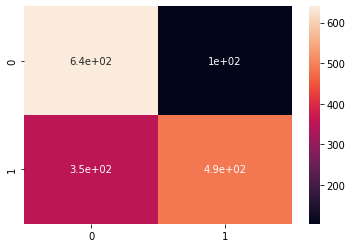

In [ ]:
matriz_confusion_sin_lim = metrics.confusion_matrix(y_test, y_predict)
sns.heatmap(matriz_confusion_sin_lim, annot=True)

También nos interesa ver ciertas métricas, para evaluar que tan correctos fueron nuestros resultados.

In [ ]:
metrics.accuracy_score(y_test, y_predict)

0.7118537200504413


# Cross validation

In [ ]:
cross_val_clf = RandomForestClassifier(criterion="entropy", max_depth=10)

In [ ]:
cross_validate(cross_val_clf, X_data, y_data, cv=4, scoring=('accuracy'))

{'fit_time': array([0.68312693, 0.6678431 , 0.86077476, 0.8379488 ]),
 'score_time': array([0.07591295, 0.13029742, 0.13323092, 0.12669182]),
 'test_score': array([0.70499244, 0.71659102, 0.71796165, 0.73562059])}

In [ ]:
cross_val_clf = RandomForestClassifier(criterion="entropy", n_estimators=200, max_depth=3)

In [ ]:
cross_validate(cross_val_clf, X_data, y_data, cv=4)

{'fit_time': array([0.44749999, 0.45678711, 0.45190763, 0.45457149]),
 'score_time': array([0.05228639, 0.05121255, 0.05612564, 0.05050373]),
 'test_score': array([0.71255673, 0.71255673, 0.71089808, 0.73259334])}

# Decision Tree Code

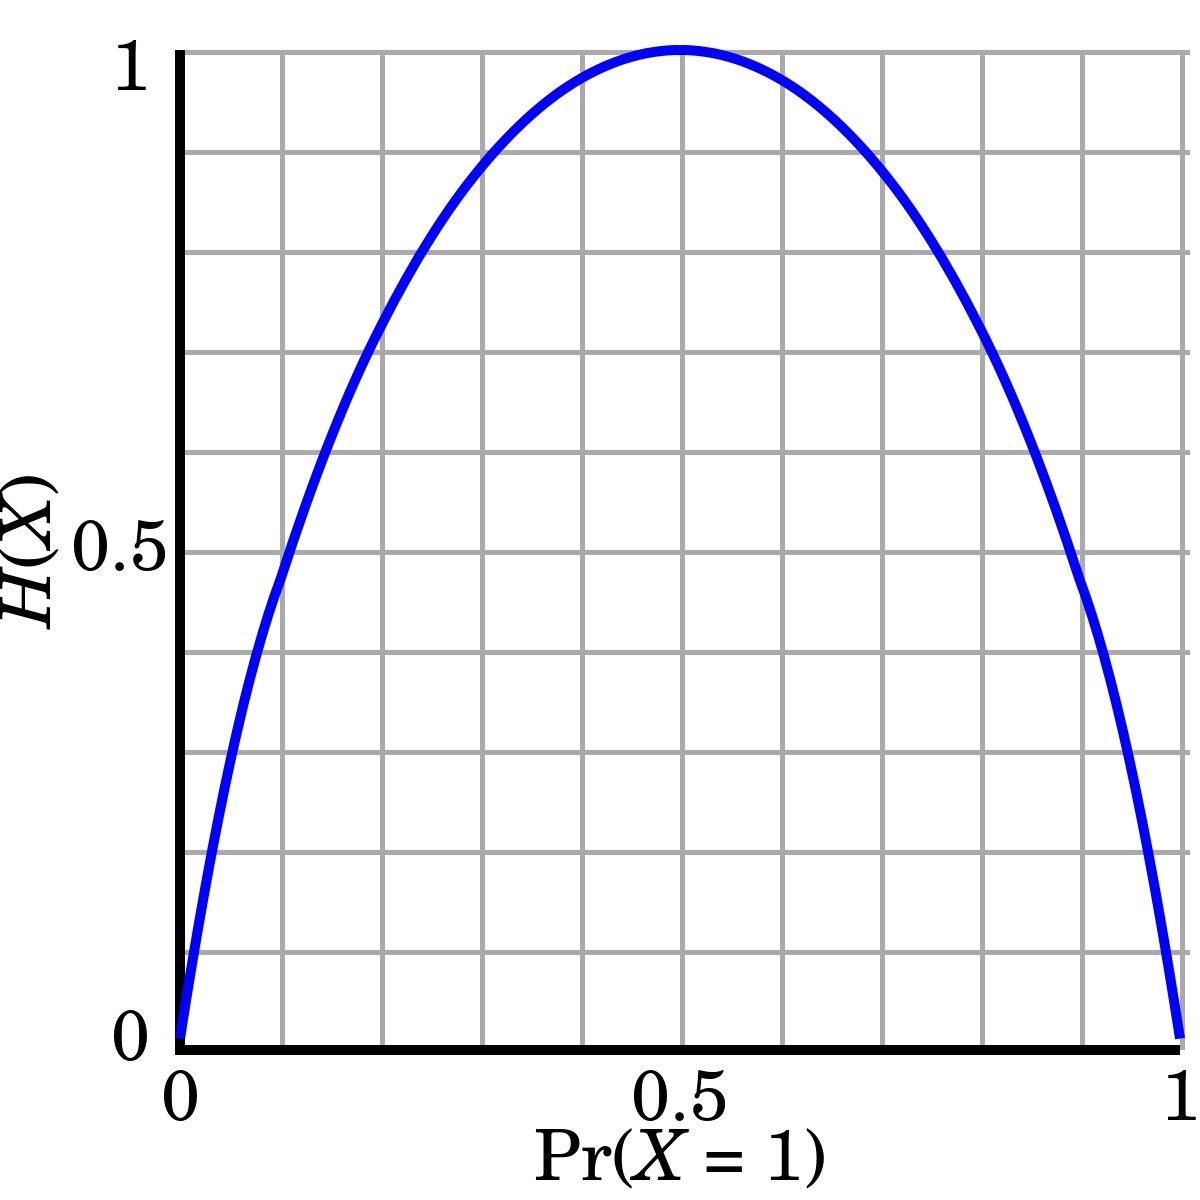

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [ ]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    # Se construye el árbol    
    def build_tree(self, dataset, curr_depth=0): 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    # Se encuentra el mejor split
    def get_best_split(self, dataset, num_samples, num_features):        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    # Función para hacer split
    def split(self, dataset, feature_index, threshold):        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    # Calcular ganancia de información
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    # Calcular entropía
    def entropy(self, y):    
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    # Calcular Giny Index
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    # Encontrar el valor de cada hoja
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    # def print_tree(self, tree=None, indent=" "):
    #     if not tree:
    #         tree = self.root

    #     if tree.value is not None:
    #         print(tree.value)

    #     else:
    #         print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
    #         print("%sleft:" % (indent), end="")
    #         self.print_tree(tree.left, indent + indent)
    #         print("%sright:" % (indent), end="")
    #         self.print_tree(tree.right, indent + indent)
    
    # Entrenar el clasificador
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    # Predecir para un conjunto de datos
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    # Predecir datos individuales
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

1. https://www.kaggle.com/competitions/spaceship-titanic/data
2. https://en.wikipedia.org/wiki/Decision_tree#:~:text=A%20decision%20tree%20is%20a,only%20contains%20conditional%20control%20statements. 
3. https://www.researchgate.net/figure/Random-forests-are-collections-of-randomised-decision-trees-A-A-single-decision-tree_fig1_339279807
